
# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import shap

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor

from statistics import mean
from scipy.stats import tmean
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.inspection import plot_partial_dependence

In [3]:
# loading csv
df_original = pd.read_csv('data/final_dataset.csv').drop("Unnamed: 0", axis=1)

df = df_original.copy()

Columns (53) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
# df_original[df_original["Name"] == "Mohamed-Salah"][["xP"]].head(80).tail(40)

In [5]:
df = df.rename(columns={'GW_x': 'GW'})
# df = df[~(df['position'].isin(['GK']))]
# df = df[df['position'].isin(['MID'])]

In [6]:
# df_original[["expected_goals", "xG"]]

In [7]:
# df_original["goals_conceded"].unique()

In [8]:
# df_original.isnull().sum(axis=0).sort_values(ascending=False).head(60)

In [9]:
df_original.columns.to_list()

['Date',
 'Day',
 'Comp',
 'Round',
 'Venue',
 'Squad',
 'Opponent',
 'Start',
 'Pos',
 'Min',
 'Gls',
 'Ast',
 'PK',
 'PKatt',
 'Sh',
 'SoT',
 'CrdY',
 'CrdR',
 'Touches',
 'Tkl',
 'Int',
 'Blocks',
 'xG',
 'npxG',
 'xAG',
 'SCA',
 'GCA',
 'Cmp',
 'Att',
 'Cmp%',
 'PrgP',
 'Carries',
 'PrgC',
 'Att.1',
 'Succ',
 'Match Report',
 'Name',
 'Season',
 'Fls',
 'Fld',
 'Off',
 'Crs',
 'TklW',
 'OG',
 'PKwon',
 'PKcon',
 'WDL',
 'GoalsTeams',
 'Team Score',
 'Opp Score',
 'CS',
 'Was Home',
 'GW_x',
 'neutral_name_x',
 'FPL_name',
 'FPL_team',
 'FPL_opp_team',
 'index',
 'season',
 'name',
 'position',
 'team',
 'assists',
 'bonus',
 'bps',
 'clean_sheets',
 'creativity',
 'element',
 'fixture',
 'goals_conceded',
 'goals_scored',
 'ict_index',
 'influence',
 'kickoff_time',
 'minutes',
 'opponent_team',
 'opp_team_name',
 'own_goals',
 'penalties_missed',
 'penalties_saved',
 'red_cards',
 'round',
 'saves',
 'selected',
 'team_a_score',
 'team_h_score',
 'threat',
 'total_points',
 'trans

In [10]:
# df["position"].unique()

In [11]:
df.shape

(24683, 117)

# Features

In [12]:
# rolling_gameweeks = [2, 3, 5, 10, 20, 30]
rolling_gameweeks = [2, 4, 30]

to_predict = ["total_points"]
features1 = [
             "Was Home", # Home/Away
             "Team rating", "Opp rating", "Rating Difference", # Team ratings
             'Team Tier', 'Opp Tier' # Subjective tier
             ]
features_to_roll = [
                "Min", "Start", # time played
                'Gls', 'Sh', 'SoT', # Goals
                'Ast', # Assists
                'CrdY', 'CrdR', # Cards
                "xG", 'xAG', # Expected
                'CS', # Defence
                'Team Score', 'Opp Score', 'Team Result', # Team form
                # "xGPoints", "CSPoints", # Position-scaled
                # "Cmp%", "PrgP", "PrgC", "Succ", "PKwon",
                # 'bonus', 'bps', # Bonus
                # 'influence', 'creativity', 'threat', 'ict_index', # ICT
                "total_points", "Baseline Points", "bonus" # FPL points
            ]
info = ["Name", "GW", "Season", "Squad", "Opponent", "Was Home", "Team rating", "Opp rating", "position"]

In [13]:
# df[features_to_roll + info].isnull().sum(axis=0).sort_values(ascending=False).head(30)

# Preparing dataset

In [14]:
df["Rating Difference"] = df["Team rating"] / df["Opp rating"]
# df["Rating Difference2"] = df["Team rating"] > df["Opp rating"]
df["Baseline Points"] = df["total_points"] - df["bonus"]

In [15]:
df["Squad"].unique()

array(['West Ham', 'Brentford', 'Arsenal', 'Manchester Utd', 'Everton',
       'Southampton', 'Leeds United', 'Brighton', 'Bournemouth', 'Wolves',
       'Crystal Palace', 'Fulham', 'Aston Villa', 'Liverpool',
       'Newcastle Utd', "Nott'ham Forest", 'Chelsea', 'Tottenham',
       'Manchester City', 'Leicester City', 'Burnley', 'Norwich City',
       'Watford', 'Dynamo Kyiv', 'Shakhtar'], dtype=object)

In [16]:
def assign_team_strength(row, team_column):
    tierS = ['Manchester City', 'Arsenal']
    tierA = ['Liverpool', 'Tottenham', 'Manchester Utd', 'Newcastle Utd', 'Chelsea', ]
    tierB = ['Brentford', 'West Ham', 'Everton', 'Brighton', 'Crystal Palace', 'Fulham', 'Aston Villa']
    tierC = ['Southampton', 'Leeds United', 'Bournemouth', 'Wolves', "Nott'ham Forest", 'Leicester City', 'Burnley', 'Watford']
    
    if row[team_column] in tierS:
        return 3
    if row[team_column] in tierA:
        return 2
    if row[team_column] in tierB:
        return 1
    return 0

df['Team Tier'] = df.apply(assign_team_strength, team_column="Squad", axis=1)
df['Opp Tier'] = df.apply(assign_team_strength, team_column="Opponent", axis=1)

In [17]:
def calculate_team_points(row):
    if row['Team Score'] > row['Opp Score']:
        return 3
    elif row['Team Score'] == row['Opp Score']:
        return 1
    else:
        return 0
    
df['Team Result'] = df.apply(calculate_team_points, axis=1)

In [18]:
def calculate_xg_points(row):
    if row["position"] == "GK":
        return row["xG"] * 6
    elif row["position"] == "DEF":
        return row["xG"] * 6
    elif row["position"] == "MID":
        return row["xG"] * 5
    elif row["position"] == "FWD":
        return row["xG"] * 4
    else:
        return row["xG"] * 5

df["xGPoints"] = df.apply(calculate_xg_points, axis=1)

In [19]:
def calculate_cs_points(row):
    if row["position"] == "GK":
        return row["xG"] * 4
    elif row["position"] == "DEF":
        return row["xG"] * 4
    elif row["position"] == "MID":
        return row["xG"] * 1
    elif row["position"] == "FWD":
        return row["xG"] * 0
    else:
        return row["xG"] * 1

df["CSPoints"] = df.apply(calculate_cs_points, axis=1)

In [20]:
def add_rolling_features(df, features1, features_to_roll):
    features = features1
    
    for r in rolling_gameweeks:
        form_means = df.groupby(["Name"])[features_to_roll].rolling(r, min_periods=1).mean().groupby(["Name"]).shift(1).reset_index()
        form_means = form_means.fillna(method='bfill')
        
        form_means.columns = [f'{col}{"_"}{r}' for col in form_means.columns]
        features += form_means.columns.tolist()
        features = list(filter(lambda x: x not in ["Name_" + str(r)], features))
        df = pd.concat([df, form_means], axis=1)
        
    return df, features

In [21]:
def ohe(df, ohe_columns, features):
    # one hot encoding
    for c in ohe_columns:
        ohe_c = pd.get_dummies(df[c], dtype="int64")
        df = pd.concat([df, ohe_c], axis=1)

        features += ohe_c.columns.tolist()
        
    return df, features

In [22]:
def label_encoding(df, column_to_encode):
    
    mapping_dict = {
        'Y': 1, # Starting eleven
        'Y*': 1, # Starting eleven as captain
        'N': 0, # Not in starting eleven
    }
    
    df[column_to_encode] = df[column_to_encode].map(mapping_dict)
    
    return df

In [23]:
df = df.reset_index()

In [24]:
df, features = add_rolling_features(df, features1, features_to_roll)

In [25]:
# df, features = ohe(df, ["position"], features)

In [26]:
df = label_encoding(df, "Start")

In [27]:
# dropping unwanted columns
features = [col for col in features if not col.startswith('level')]
df = df[np.unique(features + info + to_predict)]

In [28]:
df = df[pd.to_numeric(df["GW"], errors="coerce").notna()]
df["GW"] = df["GW"].astype("uint64")

In [29]:
# dropping NaNs
df = df.dropna(axis=0)

In [30]:
df = df.set_index(["Name", "Season", "GW"], drop=False)

In [31]:
df.columns

Index(['Ast_2', 'Ast_30', 'Ast_4', 'Baseline Points_2', 'Baseline Points_30',
       'Baseline Points_4', 'CS_2', 'CS_30', 'CS_4', 'CrdR_2', 'CrdR_30',
       'CrdR_4', 'CrdY_2', 'CrdY_30', 'CrdY_4', 'GW', 'Gls_2', 'Gls_30',
       'Gls_4', 'Min_2', 'Min_30', 'Min_4', 'Name', 'Opp Score_2',
       'Opp Score_30', 'Opp Score_4', 'Opp Tier', 'Opp rating', 'Opponent',
       'Rating Difference', 'Season', 'Sh_2', 'Sh_30', 'Sh_4', 'SoT_2',
       'SoT_30', 'SoT_4', 'Squad', 'Team Result_2', 'Team Result_30',
       'Team Result_4', 'Team Score_2', 'Team Score_30', 'Team Score_4',
       'Team Tier', 'Team rating', 'Was Home', 'bonus_2', 'bonus_30',
       'bonus_4', 'position', 'total_points', 'total_points_2',
       'total_points_30', 'total_points_4', 'xAG_2', 'xAG_30', 'xAG_4', 'xG_2',
       'xG_30', 'xG_4'],
      dtype='object')

In [32]:
df.shape

(22151, 61)

# Choosing features and splitting data

In [33]:
GAMEWEEK_TO_PREDICT = 30
SEASON_TO_PREDICT = "2022-23"

In [34]:
# gameweeks 6-14 is training data, gw 15 is test data
X_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][features].reset_index(drop=True)
y_train = df[((df["Season"] < SEASON_TO_PREDICT) | (df["GW"] <= GAMEWEEK_TO_PREDICT - 1))][to_predict].reset_index(drop=True)

In [35]:
X_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [36]:
X_test_all_remaining = df[(df["GW"] >= GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][features].reset_index(drop=True)
y_test_all_remaining = df[(df["GW"] >= GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) ][to_predict].reset_index(drop=True)

In [37]:
X_train.shape, X_test.shape

((18822, 54), (375, 54))

# Model

In [38]:
class HybridModel:
    def __init__(self, models, names, weights):
        self.models = models
        self.model_names = names
        self.weights = weights
    
    def fit(self, X, y):
        for model in self.models:
            model.fit(X, y)
        
    def predict(self, X):
        model_preds = [model.predict(X) for model in self.models]
        preds = []
        for i in range(len(model_preds[0])):
            preds.append(np.mean([x[i] for x in model_preds]))
        return preds
    
    def evaluate(self, X, y):
        ys = [np.expm1(model.predict(X)) for model in self.models]
        y_ensemble = self.predict(X)
        
        rmsle_ys = [(mean_squared_log_error(y, y_model) ** 0.5) for y_model in ys]
        rmsle_ensemble = mean_squared_log_error(y, y_ensemble) ** 0.5
        
        for i in range(0, len(self.models)):
            print(f"RMSLE on {self.model_names[i]} model: {rmsle_ys[i]}")
        print(f"RMSLE on ensemble model: {rmsle_ensemble}")

In [39]:
lgbm = LGBMRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
gbr = GradientBoostingRegressor(random_state=42)

names = [
    "LGBM",
    "XGB",
    "GBR"
]

weights = [
    1,
    1,
    1
]

# hybrid arguments
models = [
    lgbm, 
    xgb, 
    gbr
]

model = HybridModel(models, names, weights)

In [40]:
model = GradientBoostingRegressor(random_state=42)
# model = LGBMRegressor(random_state=42)
# model = XGBRegressor(random_state=42)
# model = RandomForestRegressor()

In [41]:
%%time
model.fit(X_train, np.array(y_train).ravel())

CPU times: total: 7.16 s
Wall time: 7.19 s


GradientBoostingRegressor(random_state=42)

# Evaluation

In [42]:
def get_predictions(model, df, X, all_remaining=False):
    # make predictions on the test data
    predictions = model.predict(X)
    
    if all_remaining:
        df_predictions = df[(df["GW"] >= GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
    else:
        df_predictions = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT)].reset_index(drop=True)
        
    df_predictions.loc[:, "pred"] = predictions
    
    preds = df_predictions[info + to_predict + ["pred"]].sort_values(by=["pred"], ascending = False)
    
    return preds, predictions

In [43]:
preds, predictions = get_predictions(model, df, X_test)

In [44]:
def pairwise_accuracy(predicted_scores, true_scores):
    if len(predicted_scores) != len(true_scores):
        raise ValueError("The length of predicted_scores and true_scores must be the same.")

    num_pairs = 0
    num_correct_pairs = 0

    for i in range(len(predicted_scores)):
        for j in range(i + 1, len(predicted_scores)):
            # Check if the predicted order matches the true order
            if (predicted_scores[i] > predicted_scores[j] and true_scores[i] > true_scores[j]) or \
               (predicted_scores[i] < predicted_scores[j] and true_scores[i] < true_scores[j]):
                num_correct_pairs += 1
            num_pairs += 1

    pairwise_accuracy = num_correct_pairs / num_pairs
    return pairwise_accuracy

In [45]:
def get_top_performer_names(df, no_top, no_gws):
    return df.reset_index(drop=True).groupby("Name")["total_points"].mean().groupby("Name").tail(no_gws).sort_values(ascending=False).head(no_top).index.to_list()

In [46]:
def pairwise_accuracy_topX(model, df, top_x):
    top_performers = df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, top_x, 50)))]
    X = top_performers[features].reset_index(drop=True)
    y = np.array(top_performers[to_predict].reset_index(drop=True))
    preds = model.predict(X)
    
    return  pairwise_accuracy(preds, y)

In [47]:
def evaluate(model, df, predictions, y_true):
    mae = mean_absolute_error(y_true, predictions)
    mse = mean_squared_error(y_true, predictions)

    pairwise_acc = pairwise_accuracy(np.array(y_true), predictions)
    pairwise_accuracy_top20 = pairwise_accuracy_topX(model, df, 20)
    pairwise_accuracy_top100 = pairwise_accuracy_topX(model, df, 100)
    
    print("MAE:", mae)
    print("MSE:", mse)
    print("Pairwise accuracy:", pairwise_acc)
    print("Pairwise accuracy @TOP100:", pairwise_accuracy_top100)
    print("Pairwise accuracy @TOP20:", pairwise_accuracy_top20)

In [48]:
# df[(df["GW"] == GAMEWEEK_TO_PREDICT) & (df["Season"] == SEASON_TO_PREDICT) & (df["Name"].isin(get_top_performer_names(df, 20, 50)))].columns

In [49]:
evaluate(model, df, predictions, y_test)

MAE: 1.76933261362131
MSE: 6.07619657081888
Pairwise accuracy: 0.5583600713012478
Pairwise accuracy @TOP100: 0.550140056022409
Pairwise accuracy @TOP20: 0.6470588235294118


In [50]:
# df[df["Name"] == "Abdoulaye-Doucoure"][info]

In [51]:
# model.predict(df[df["GW"] == GAMEWEEK_TO_PREDICT][df["Name"] == "Mohamed-Salah"][features])

# Valid predictions

In [52]:
preds.head(30)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
126,Harry-Kane,30,2022-23,Tottenham,Brighton,1.0,1848.280518,1835.872314,FWD,9.0,5.861188
109,Erling-Haaland,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,FWD,12.0,5.725006
316,Rodri,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,2.0,5.584949
144,Ivan-Toney,30,2022-23,Brentford,Newcastle Utd,1.0,1792.455444,1871.874634,FWD,4.0,5.179920
209,Kevin-De-Bruyne,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,9.0,4.908169
285,Ollie-Watkins,30,2022-23,Aston Villa,Nott'ham Forest,1.0,1799.512573,1643.347290,FWD,7.0,4.690210
156,James-Maddison,30,2022-23,Leicester City,Bournemouth,1.0,1736.191162,1656.900146,MID,2.0,4.686203
265,Mohamed-Salah,30,2022-23,Liverpool,Arsenal,1.0,1929.042725,1956.794434,MID,5.0,4.610295
339,Son-Heung-min,30,2022-23,Tottenham,Brighton,1.0,1848.280518,1835.872314,MID,7.0,4.574069
242,Marcus-Rashford,30,2022-23,Manchester Utd,Everton,1.0,1880.802124,1694.970825,MID,6.0,4.457278


In [53]:
preds[preds["Squad"] == "Manchester City"].head(20)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
109,Erling-Haaland,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,FWD,12.0,5.725006
316,Rodri,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,2.0,5.584949
209,Kevin-De-Bruyne,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,9.0,4.908169
98,Ederson,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,GK,2.0,4.263803
145,Jack-Grealish,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,12.0,4.079129
139,Ilkay-Gundogan,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,MID,2.0,4.013272
272,Nathan-Ake,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DEF,2.0,3.971576
320,Ruben-Dias,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DEF,2.0,3.951146
236,Manuel-Akanji,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DEF,2.0,3.936248
187,John-Stones,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,DEF,0.0,3.629213


In [54]:
# preds[preds["position"] == "FWD"].head(15)
preds_all, predictions_all = get_predictions(model, df, X_test_all_remaining, True)

In [55]:
preds_all.head(15)

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
1011,Erling-Haaland,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,FWD,2.0,9.377604
1858,Kevin-De-Bruyne,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,MID,3.0,7.830953
1013,Erling-Haaland,37,2022-23,Manchester City,Chelsea,1.0,2090.251709,1797.171265,FWD,1.0,6.500012
1010,Erling-Haaland,34,2022-23,Manchester City,Fulham,0.0,2067.576904,1720.540771,FWD,8.0,6.340688
2391,Mohamed-Salah,37,2022-23,Liverpool,Aston Villa,1.0,1958.159424,1815.086426,MID,5.0,6.290897
1181,Harry-Kane,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,FWD,2.0,6.198268
1960,Leandro-Trossard,31,2022-23,Arsenal,West Ham,0.0,1957.524048,1754.553955,MID,1.0,6.171366
2388,Mohamed-Salah,34,2022-23,Liverpool,Tottenham,1.0,1936.814331,1820.079712,MID,7.0,6.087694
1185,Harry-Kane,35,2022-23,Tottenham,Crystal Palace,1.0,1816.056030,1752.288574,FWD,8.0,6.074408
2392,Mohamed-Salah,38,2022-23,Liverpool,Southampton,0.0,1953.153564,1619.777344,MID,5.0,6.030483


In [56]:
preds_all[preds_all["Name"] == "Mohamed-Salah"].sort_values(by=["GW"])

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
2384,Mohamed-Salah,30,2022-23,Liverpool,Arsenal,1.0,1929.042725,1956.794434,MID,5.0,4.610295
2385,Mohamed-Salah,31,2022-23,Liverpool,Leeds United,0.0,1928.520996,1698.080566,MID,14.0,4.946761
2386,Mohamed-Salah,32,2022-23,Liverpool,Nott'ham Forest,1.0,1930.005737,1626.679321,MID,7.0,4.391583
2387,Mohamed-Salah,33,2022-23,Liverpool,West Ham,0.0,1931.599731,1774.066772,MID,2.0,4.452909
2388,Mohamed-Salah,34,2022-23,Liverpool,Tottenham,1.0,1936.814331,1820.079712,MID,7.0,6.087694
2389,Mohamed-Salah,35,2022-23,Liverpool,Brentford,1.0,1943.223999,1784.843750,MID,10.0,5.245819
2390,Mohamed-Salah,36,2022-23,Liverpool,Leicester City,0.0,1947.327637,1712.013672,MID,12.0,4.976119
2391,Mohamed-Salah,37,2022-23,Liverpool,Aston Villa,1.0,1958.159424,1815.086426,MID,5.0,6.290897
2392,Mohamed-Salah,38,2022-23,Liverpool,Southampton,0.0,1953.153564,1619.777344,MID,5.0,6.030483


In [57]:
preds_all[preds_all["Name"] == "Erling-Haaland"].sort_values(by=["GW"])

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
1007,Erling-Haaland,30,2022-23,Manchester City,Southampton,0.0,2051.762451,1657.546753,FWD,12.0,5.725006
1008,Erling-Haaland,31,2022-23,Manchester City,Leicester City,1.0,2063.473633,1725.040527,FWD,12.0,5.885487
1014,Erling-Haaland,32,2022-23,Manchester City,Brighton,0.0,2091.929932,1829.306519,FWD,5.0,4.075386
1009,Erling-Haaland,33,2022-23,Manchester City,Arsenal,1.0,2060.745117,1938.854858,FWD,14.0,5.930062
1010,Erling-Haaland,34,2022-23,Manchester City,Fulham,0.0,2067.576904,1720.540771,FWD,8.0,6.340688
1011,Erling-Haaland,35,2022-23,Manchester City,Leeds United,1.0,2072.109375,1665.195679,FWD,2.0,9.377604
1012,Erling-Haaland,36,2022-23,Manchester City,Everton,0.0,2074.110596,1697.794434,FWD,7.0,5.678459
1013,Erling-Haaland,37,2022-23,Manchester City,Chelsea,1.0,2090.251709,1797.171265,FWD,1.0,6.500012
1015,Erling-Haaland,38,2022-23,Manchester City,Brentford,0.0,2086.425293,1809.881592,FWD,0.0,5.339040


In [58]:
preds_all[preds_all["Name"] == "Harry-Kane"].sort_values(by=["GW"])

,Name,GW,Season,Squad,Opponent,Was Home,Team rating,Opp rating,position,total_points,pred
1180,Harry-Kane,30,2022-23,Tottenham,Brighton,1.0,1848.280518,1835.872314,FWD,9.0,5.861188
1181,Harry-Kane,31,2022-23,Tottenham,Bournemouth,1.0,1854.798462,1668.258545,FWD,2.0,6.198268
1182,Harry-Kane,32,2022-23,Tottenham,Newcastle Utd,0.0,1834.483765,1857.315674,FWD,6.0,4.811858
1183,Harry-Kane,33,2022-23,Tottenham,Manchester Utd,1.0,1820.470093,1854.124756,FWD,11.0,5.788735
1184,Harry-Kane,34,2022-23,Tottenham,Liverpool,0.0,1820.079712,1936.814331,FWD,8.0,4.642812
1185,Harry-Kane,35,2022-23,Tottenham,Crystal Palace,1.0,1816.056030,1752.288574,FWD,8.0,6.074408
1186,Harry-Kane,36,2022-23,Tottenham,Aston Villa,0.0,1822.077881,1803.241211,FWD,7.0,4.912383
1187,Harry-Kane,37,2022-23,Tottenham,Brentford,1.0,1819.507935,1796.138916,FWD,7.0,5.321700
1188,Harry-Kane,38,2022-23,Tottenham,Leeds United,0.0,1805.765259,1667.934448,FWD,16.0,5.668987


# Feature importance and influence

In [59]:
# plot_importance(model)

In [60]:
# fig, ax = plt.subplots(figsize=(16, 8))
# plot_partial_dependence(model, X_train, features, ax=ax)

In [61]:
explainer = shap.Explainer(model.predict, X_test)
shap_values = explainer(X_test)

Permutation explainer: 376it [00:26,  9.91it/s]                                                                                                                                    


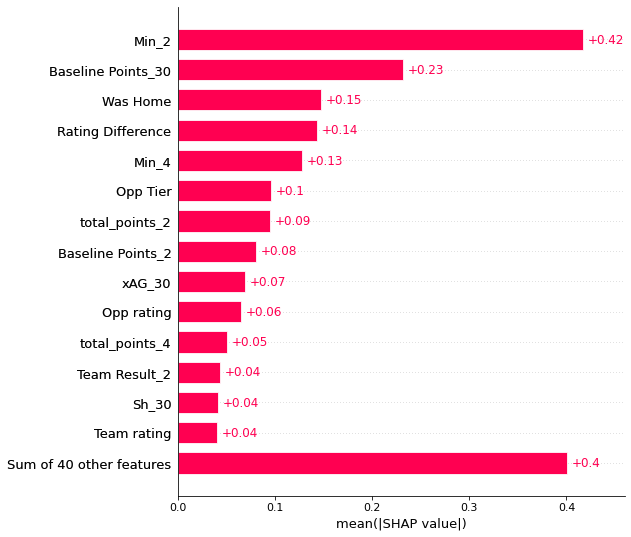

In [62]:
shap.plots.bar(shap_values, max_display=15)

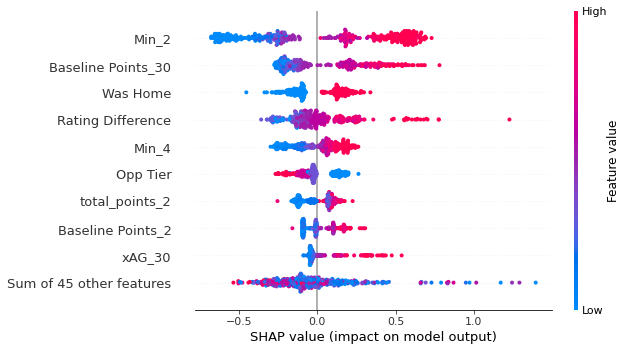

In [63]:
shap.plots.beeswarm(shap_values)

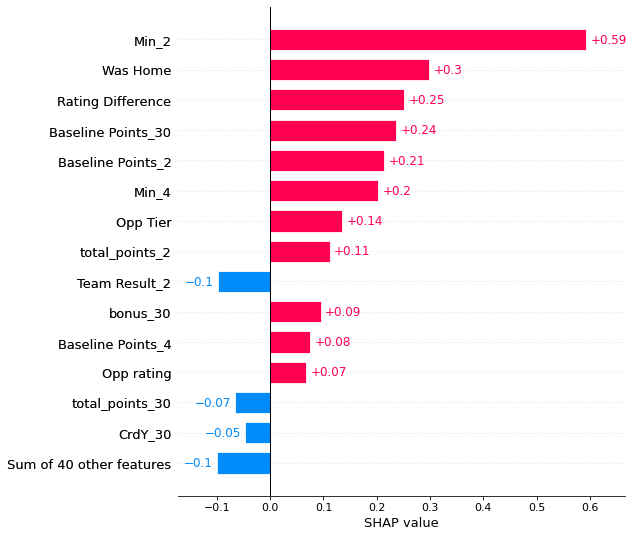

In [64]:
shap.plots.bar(shap_values[105], max_display=15)